<h1> Building the Deutsch-Jozsa Algorithm on the Qiskit Framework

In [161]:
from qiskit import __version__
assert __version__ == '2.0.0', f"Qiskit 2.0.0 is required, but found {__version__}."
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution

Basic Circuit Diagram for Deustch Josza Algorithm

<div style="text-align: center;">
<img src="Deutsh-Jozsa.png" width='80%'>
</div>

## Building a balanced Oracle

The Oracle circuit:

<div style="text-align: center;">
    <img src="balanced_oracle.png" alt="Balanced Oracle" width="30%">
</div>

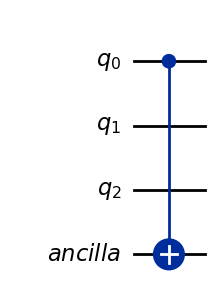

In [162]:
def balanced_3_qubit_oracle(qr:QuantumRegister, ancilla:QuantumRegister, draw:bool=False) -> qiskit.circuit.Gate:

    qc = QuantumCircuit(qr, ancilla)

    qc.cx(qr[0], ancilla)

    gate = qc.to_gate(label='Balanced Oracle')
    gate.name = 'Balanced Oracle'

    if draw:
        return qc

    return gate

balanced_3_qubit_oracle(QuantumRegister(3, 'q'), QuantumRegister(1, 'ancilla'), draw=True).draw('mpl')

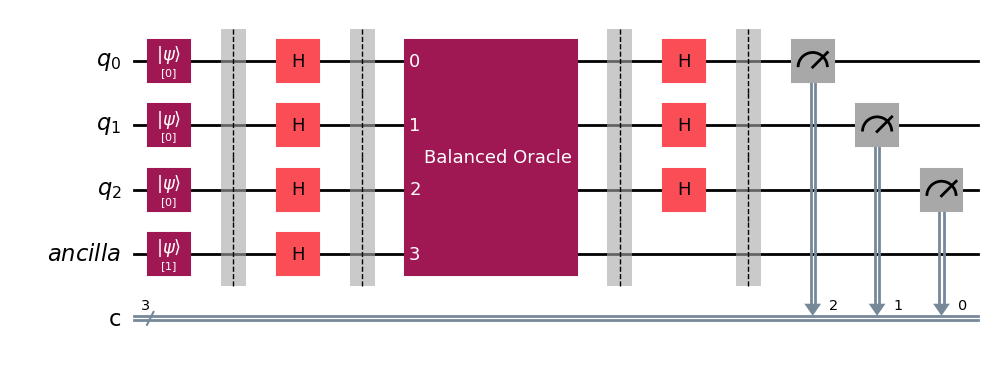

In [163]:
def balanced_3_qb_dj_alg(init_states:list, oracle_func=balanced_3_qubit_oracle) -> QuantumCircuit:

    qr = QuantumRegister(3, 'q')
    ancilla = QuantumRegister(1, 'ancilla')

    cr = ClassicalRegister(3, 'c')
    # ancilla_cr = ClassicalRegister(1, 'ancilla_c')

    qc = QuantumCircuit(qr, ancilla, cr)

    # initialize the qubit states
    qc.initialize(init_states[0], qr[0])
    qc.initialize(init_states[1], qr[1])
    qc.initialize(init_states[2], qr[2])

    if len(init_states) > 3:
        qc.initialize(init_states[3], ancilla[0])
    else:
        qc.initialize(1, ancilla)

    qc.barrier()

    # Apply Hadamard gates to all qubits
    qc.h(qr)
    qc.h(ancilla)

    qc.barrier()

    # Apply the balanced oracle
    oracle = oracle_func(qr, ancilla)
    qc.append(oracle, range(4))

    qc.barrier()

    # Apply Hadamard gates to qubits again
    qc.h(qr)

    qc.barrier()
    
    # Measure the qubits
    for i in range(3):
        qc.measure(qr[i], cr[3-i-1])

    # qc.measure(ancilla[0], cr[3])
    # qc.measure(ancilla[0], ancilla_cr[0])

    return qc

init = ['0', '0', '0'] + ['1']
qc = balanced_3_qb_dj_alg(init_states=init)
qc.draw('mpl')

### Simulation

In [164]:
from qiskit_aer import AerSimulator
from qiskit import transpile
import matplotlib.pyplot as plt

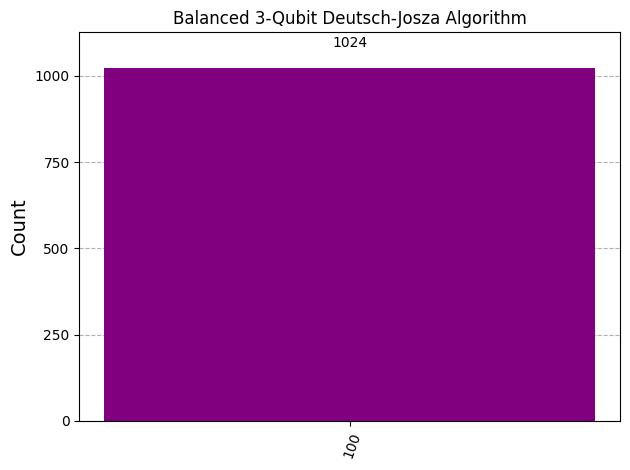

In [165]:
init = [0, 0, 0, 1]

qc = balanced_3_qb_dj_alg(init_states=init)
backend = AerSimulator()
qc = transpile(qc, backend=backend, optimization_level=0)

job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts(qc)

plot_histogram(counts, title='Balanced 3-Qubit Deutsch-Josza Algorithm', color='purple')


In [166]:
legends = []
backend = AerSimulator(method='statevector')
counts = []
results = []

ancilla_bit = 1

for i in range(2**3):
    print(f"Initial state configuration: {i:03b} - {ancilla_bit}")
    init = [int(x) for x in f"{i:03b}"] + [ancilla_bit]

    legends.append(f"{init[0]}{init[1]}{init[2]} - {ancilla_bit}")
    qc = balanced_3_qb_dj_alg(init_states=init)

    # print(qc.draw('text'))

    qc = transpile(qc, backend=backend, optimization_level=0)
    job = backend.run(qc, shots=1024)
    result = job.result()
    counts.append(result.get_counts(qc))
    
    results.append(result.get_counts(qc))

Initial state configuration: 000 - 1
Initial state configuration: 001 - 1
Initial state configuration: 010 - 1
Initial state configuration: 011 - 1
Initial state configuration: 100 - 1
Initial state configuration: 101 - 1
Initial state configuration: 110 - 1
Initial state configuration: 111 - 1


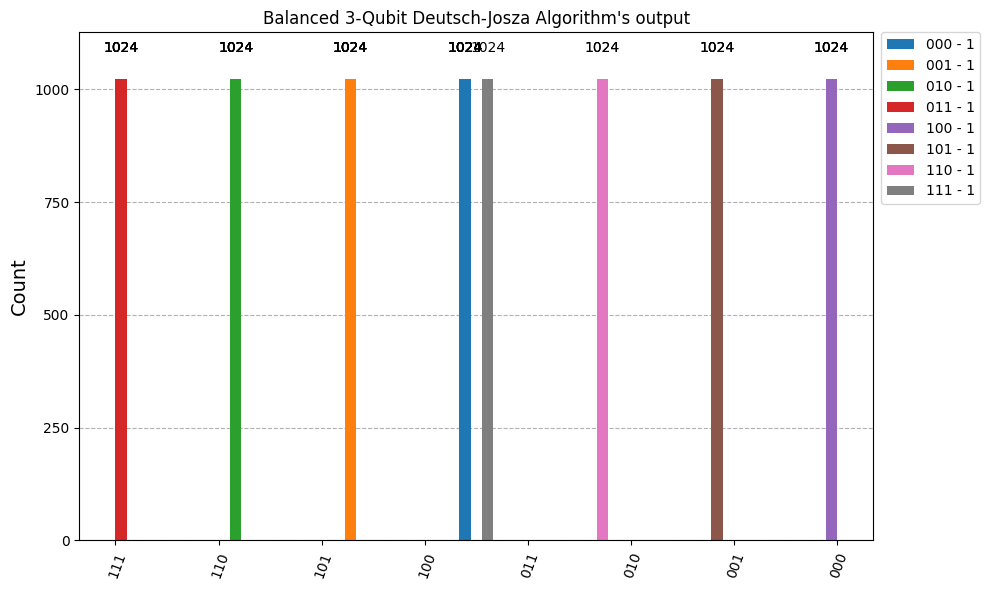

In [167]:
plot_histogram(counts, title=f'Balanced 3-Qubit Deutsch-Josza Algorithm\'s output', 
               legend=legends, figsize=(10, 6), sort='desc' )

### Conclusions:

The algorithm inverts the first qbit when the ancilla gate is set to 1 as expected: the H gates compined with the CNOT gate behave as a single inverted CNOT gate.

As expected but doing a query of initial state $\ket{000}\otimes\ket{1}$ we only get ${\ket{100}\otimes\ket{1} }$

Thus the porbability of finding $\ket{000}$ is:
$$ P(\ket{000}) = 0 $$

## Another balanced Oracle

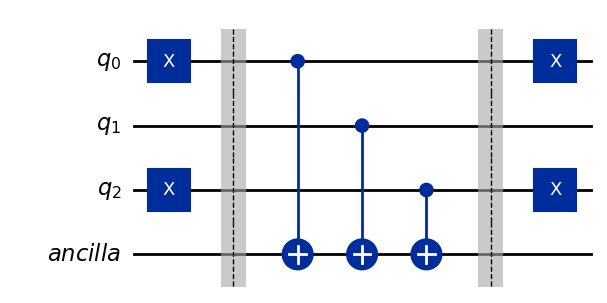

In [168]:
def balanced_3_qb_oracle_2(qr:QuantumRegister, ancilla:QuantumRegister, draw=False) -> qiskit.circuit.Gate:

    qc = QuantumCircuit(qr, ancilla)

    qc.x(qr[0])
    qc.x(qr[2])

    if draw:
        qc.barrier()

    # qc.cx(target_qubit=qr[0], control_qubit=ancilla[0])
    # qc.cx(target_qubit=qr[1], control_qubit=ancilla[0])
    # qc.cx(target_qubit=qr[2], control_qubit=ancilla[0])

    qc.cx(qr[0], ancilla[0])
    qc.cx(qr[1], ancilla[0])
    qc.cx(qr[2], ancilla[0])
    

    if draw:
        qc.barrier()

    qc.x(qr[0])
    qc.x(qr[2])

    if draw:
        return qc

    gate = qc.to_gate(label='Balanced Oracle')
    gate.name = 'Balanced Oracle'

    return gate


balanced_3_qb_oracle_2(QuantumRegister(3, 'q'), QuantumRegister(1, 'ancilla'), draw=True).draw('mpl')

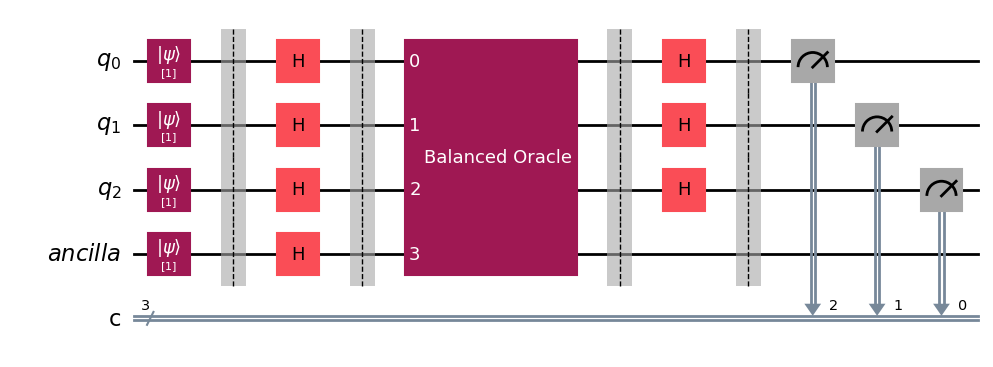

In [169]:
qc = balanced_3_qb_dj_alg(init_states=init, oracle_func=balanced_3_qb_oracle_2)
qc.draw('mpl')

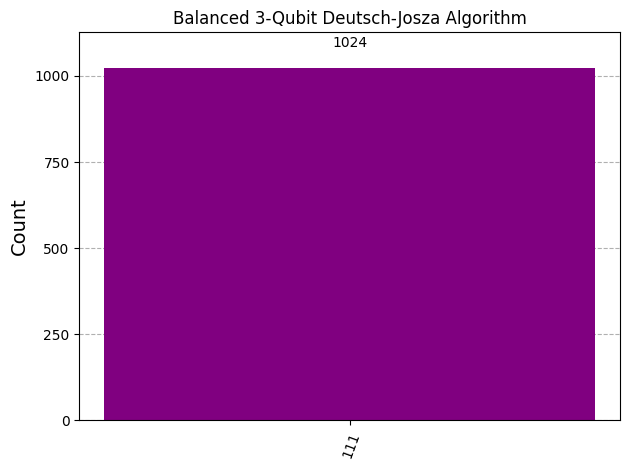

In [170]:
init = [0, 0, 0, 1]

sim = AerSimulator(method='statevector')
qc = balanced_3_qb_dj_alg(init_states=init, oracle_func=balanced_3_qb_oracle_2)
qc = transpile(qc, backend=sim, optimization_level=0)
qc.draw('mpl')
job = sim.run(qc, shots=1024)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Balanced 3-Qubit Deutsch-Josza Algorithm', color='purple')

Initial state configuration: 000
Initial state configuration: 001
Initial state configuration: 010
Initial state configuration: 011
Initial state configuration: 100
Initial state configuration: 101
Initial state configuration: 110
Initial state configuration: 111


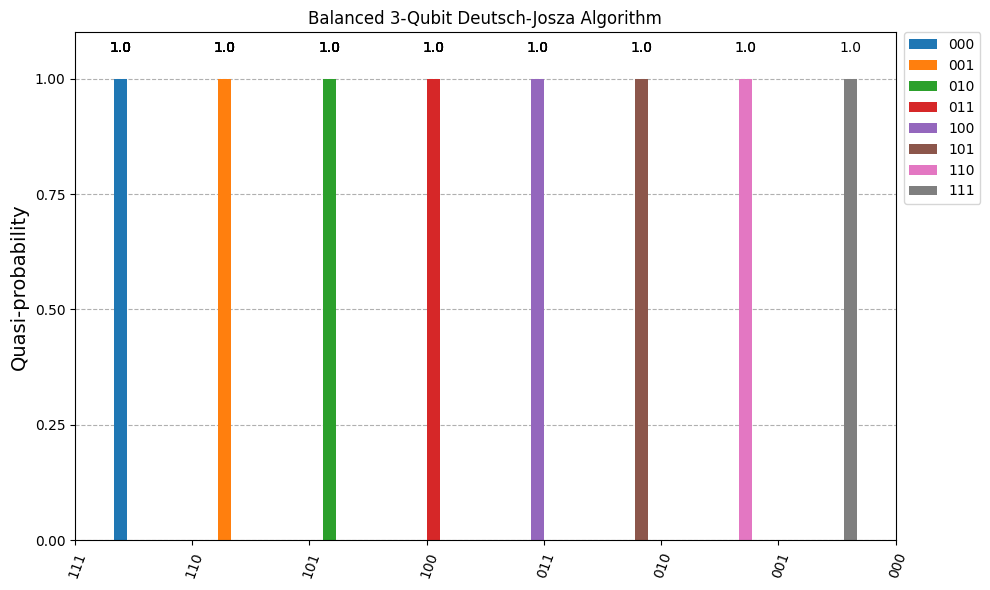

In [171]:
results = []
counts = []
legends = []

backend = AerSimulator(method='statevector')

for i in range(2**3):
    print(f"Initial state configuration: {i:03b}")
    init = [int(x) for x in f"{i:03b}"] + [1]

    legends.append(f"{init[0]}{init[1]}{init[2]}")
    qc = balanced_3_qb_dj_alg(init_states=init, oracle_func=balanced_3_qb_oracle_2)

    qc = transpile(qc, backend=backend, optimization_level=0)
    job = backend.run(qc, shots=1024)
    result = job.result()
    counts.append(result.get_counts(qc))

plot_distribution(counts, title=f'Balanced 3-Qubit Deutsch-Josza Algorithm',
               legend=legends, figsize=(10, 6), sort='desc' )

### Conclusion:

As expected for the single query of $\ket{000}\otimes\ket{1}$ we get $P(\ket{000}) = 0$